In [113]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
from jax import grad, vmap, jit, value_and_grad
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.random as random
from jax.lax import cond, scan
import jax.example_libraries.optimizers as optimizers
key = random.PRNGKey(2022)

from utils_node import init_params_damage, init_params_damage_simple
from utils_node import RK_forward_pass_nobias as NODE_nobias, RK_forward_pass as NODE

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import pickle

import diffrax
from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5 as mysolver
from diffrax import Heun as mysolver

In [114]:
n_damage = 1

def f(d, params):
    return jnp.exp(-1*NODE_nobias(d, params))
    # return 1.0-d
f_vmap = vmap(f, in_axes=(0, None))
def G(tau, params):
    return NODE(tau, params)
G_vmap = vmap(G, in_axes=(0, None))

def Psi1_fn(params, I1):
    params, bias = params
    return NODE_nobias(I1-3, params) + jnp.exp(bias)


def integrate_damage(params, tau_max, ddot_fn):
    """
    This takes in a ddot function of your choice and integrates it assuming 
    tau (the maximum observed value of the conjugate variable) __linearly__ 
    increases from 0 to tau_max.
    The absolute value of time (t) is not important, so it is chosen to go
    from 0.0 to 1.0.

    ddot_fn: params, tau, taudot → dd/dt
    """
    t_max = 1.0
    def yprime(t, y, args=None):
        tau = tau_max*t
        taudot = tau_max/t_max
        return ddot_fn(params, tau, taudot)
    term = ODETerm(yprime)
    solver = mysolver()
    saveat = SaveAt(ts=jnp.linspace(0,t_max))
    y0 = jnp.array([0.0])
    solution = diffeqsolve(term, solver, t0=0.0, t1=t_max, dt0=0.001, y0=y0, saveat=saveat, max_steps=1048576)
    return solution.ys


@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state):
    params = get_params(opt_state)
    g = grad(loss)(params)
    return opt_update(i, g, opt_state)

def train(loss, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None):
    train_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        opt_state = step(loss, it, get_params, opt_update, opt_state)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, metrics

In [267]:
# These functions are needed for predictions under realistic loading cases
def eval_Cauchy_singlevar(lmbx, lmby, d, params):
    params_Psi1, params_G = params

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    Cinv = jnp.linalg.inv(C)

    I1 = C[0,0] + C[1,1] + C[2,2]

    f1 = 1-d
    Psi1 = jnp.maximum(f1,0.0)*Psi1_fn(params_Psi1, I1)

    p = -C[2,2]*(2*Psi1)
    S = p*Cinv + 2*Psi1*jnp.eye(3)

    sgm = F @ (S @ F.T)
    return sgm
eval_Cauchy_vmap = vmap(eval_Cauchy_singlevar, in_axes=(0,0,0,None), out_axes = 0)
eval_Cauchy_vmap2 = vmap(eval_Cauchy_singlevar, in_axes=(0,0,None,None), out_axes = 0)

@partial(jit, static_argnums=(3,))
def ddot_singlevar(params_G, y, taudot, ddot_fn):
    """
    Difference between this function and, say, ddot_vahid: 
    1. This function checks for damage criterion.
    2. This function returns both ddot and rdot

    Differences from the ddot_fn in the other notebooks:
    1. It works with only 1 damage function (Psi_I1)
    2. It assumes f=1-d
    """
    d, r, tau = y

    #check if g<0
    g = G(tau, params_G) - G(r, params_G)
    def true_fun(): #What to return for rdot & ddot if g<0
        return 0.0, 0.0, taudot
    def false_fun():
        ddot = ddot_fn(params_G, tau, taudot)
        rdot = taudot
        return ddot, rdot, taudot
    ydot = cond(g<0, true_fun, false_fun)
    return jnp.stack(ydot)

def Psi1_uniaxial(t, params_Psi, lmb_dot):
    lmbx = 1.0 + lmb_dot*t
    I1 = lmbx**2 + 2.0/lmbx # = lmbx**2 + lmby**2 + lmbz**2
    return Psi1_fn(params_Psi, I1)

@partial(jit, static_argnums=(3,))
def integrate_d_uniax(params, lmb_max, y0, ddot_fn, saveat):
    params_Psi, params_G = params
    t_peak = 1.0
    lmb_dot = (lmb_max-1.0)/t_peak
    def yprime(t, y, args=None):
        Psidot = grad(Psi1_uniaxial)(t, params_Psi, lmb_dot)
        taudot = Psidot
        return ddot_singlevar(params_G, y, taudot, ddot_fn)
    
    term = ODETerm(yprime)
    solver = mysolver()
    saveat = SaveAt(ts=saveat)
    solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.01, y0=y0, saveat=saveat)
    return solution.ys

# @partial(jit, static_argnums=(2,3,))
def repeat_uniax(params, lmb_max_list, ddot_fn):
    params_Psi, params_G = params
    _, bias = params_Psi
    y0 = jnp.array([0.0,jnp.exp(bias),jnp.exp(bias)]) # y0 = (d0, r0, tau0)

    # t and lmb are dummy vars, but it is convenient to return them from here
    t_list   = []
    lmb_list = []
    d_list   = []
    r_list   = []
    tau_list = []
    t0 = 0.0
    for i in range(len(lmb_max_list)):
        n_points = 50
        lmb_max = lmb_max_list[i]
        saveat = jnp.linspace(0.0,1.0, n_points)

        y = integrate_d_uniax(params, lmb_max, y0, ddot_fn, saveat)
        t_load   = t0 + saveat
        lmb_load = jnp.linspace(1.0, lmb_max, n_points)
        d_load   = y[:,0] #y consists of [r, d, tau], but we don't need to return r
        r_load   = y[:,1]
        tau_load = y[:,2]

        t0+= 1.0

        #Unloading curves
        t_unload   = t0 + saveat
        lmb_unload = jnp.linspace(lmb_max, 1.0, n_points)
        d_unload   = jnp.ones_like(d_load)*d_load[-1]
        r_unload   = jnp.ones_like(r_load)*r_load[-1]
        tau_unload = jnp.ones_like(tau_load)*tau_load[-1]
        t0+= 1.0
        y0 = y[-1]
        y0 = y0.at[2].set(jnp.exp(bias))
        # print(y0.shape, y0)

        t_list  .append(jnp.hstack([  t_load,   t_unload]))
        lmb_list.append(jnp.hstack([lmb_load, lmb_unload]))
        d_list  .append(jnp.hstack([  d_load,   d_unload]))
        r_list  .append(jnp.hstack([  r_load,   r_unload]))
        tau_list.append(jnp.hstack([tau_load, tau_unload]))

    return jnp.array(t_list), jnp.array(lmb_list), jnp.clip(jnp.array(d_list), a_min=0.0, a_max=1.0)#, jnp.array(r_list), jnp.array(tau_list)

In [289]:
def plot_stress_uniax(lmbx_max_list, ddot_fn_gt, ddot_fn_pr, params_gt, params_pr, label_gt, label_pr='NODE (pr)', tau_max=1.0, d_first=True, cycle_legend=True):
    if d_first:
        i_d,i_off,i1,i2,i3 = 0,1,2,3,4
        gridspec = dict(wspace=0.4, width_ratios=[1, 0.1, 1, 1, 1])
    else:
        i1,i2,i3,i_off,i_d = 0,1,2,3,4
        gridspec = dict(wspace=0.4, width_ratios=[1, 1, 1, 0.1, 1])
    

    resize = 0.5
    # resize = 1.0
    n_ax = 4
    
    fig, ax = plt.subplots(1,n_ax+1,figsize=(5*n_ax*resize+2,4*resize), gridspec_kw=gridspec)

    tau = np.linspace(0,tau_max)
    d_gt = integrate_damage(params_gt[1], tau_max, ddot_fn_gt)
    d_pr = integrate_damage(params_pr[1], tau_max, ddot_fn_pr)
    d_pr = np.clip(d_pr, a_min=0.0, a_max=1.0)
    
    ax[i_d].plot(tau, d_gt,  '-', color='tab:green', label=label_gt)
    ax[i_d].plot(tau, d_pr, '--', color='tab:red', label=label_pr, dashes=(4, 3), linewidth=2.5)
    ax[i_d].set(xlabel='$r$ [-]', ylabel='$d(r)$ [-]')
    ax[i_d].legend(frameon=False, handlelength=1, loc='lower right')

    ax[i_off].set_visible(False) # This is just a dummy axis (turned off) to put extra space between the first subplot and the rest


    t, lmbx, d_pr = repeat_uniax(params_pr, lmbx_max_list, ddot_fn_pr)
    t, lmbx, d_gt = repeat_uniax(params_gt, lmbx_max_list, ddot_fn_gt)

    for i in range(len(t)):
        t_i = t[i]
        lmbx_i = lmbx[i]
        lmby_i = 1.0/np.sqrt(lmbx_i)
        di_gt = d_gt[i]
        di_pr = d_pr[i]

        ax[i1].plot(t_i, lmbx_i, color=plt.cm.Set2(i))

        ax[i2].plot(t[i], di_gt, color=plt.cm.Set2(i))
        ax[i2].plot(t[i], di_pr, color=plt.cm.Dark2(i), linestyle='dashed', dashes=(4, 3), linewidth=2.5)

        sgmx_gt = eval_Cauchy_vmap(lmbx_i, lmby_i, di_gt, params_gt)[:,0,0]
        sgmx_pr = eval_Cauchy_vmap(lmbx_i, lmby_i, di_pr, params_pr)[:,0,0]
        ax[i3].plot(lmbx_i, sgmx_gt, color=plt.cm.Set2(i))
        ax[i3].plot(lmbx_i, sgmx_pr, color=plt.cm.Dark2(i), linestyle='dashed', dashes=(4, 3), linewidth=2.5)


    # plot an invisible dot to increase ymax
    ax[i1].plot(0, np.max(lmbx)*1.25, alpha=0.0)
    ax[i1].set(xlabel='time [s]', ylabel = '$\lambda_x$ [-]')
    if cycle_legend:
        ax[i1].legend(['Cycle 1', 'Cycle 2', 'Cycle 3'], frameon=False, handlelength=1, loc='upper left')
    
    ax[i2].set(xlabel='time [s]', ylabel='$d$ [-]')
    ax[i3].set(xlabel='$\lambda_x$ [-]', ylabel='$\sigma_{xx}$ [kPa]')

    legend_elements = [Line2D([0], [0], color='k', linestyle= '-', label=label_gt),
                       Line2D([0], [0], color='k', linestyle='--', label=label_pr, linewidth=2.5)]
    ax[i2].legend(handles = legend_elements, frameon=False, handlelength=1, loc='lower right')

    [a.spines['top'].set_visible(False)  for a in ax]
    [a.spines['right'].set_visible(False) for a in ax]

    return fig, ax

## 0. Vahid

In [259]:
@jit
def ddot_vahid(params_G, tau, taudot):
    ddot = taudot*grad(G)(tau, params_G)
    return ddot
ddot_vahid_vmap = vmap(ddot_vahid, in_axes=(None, 0, 0))

In [260]:
tau = np.linspace(0,1)
taudot = np.ones_like(tau)

# 1. Noel

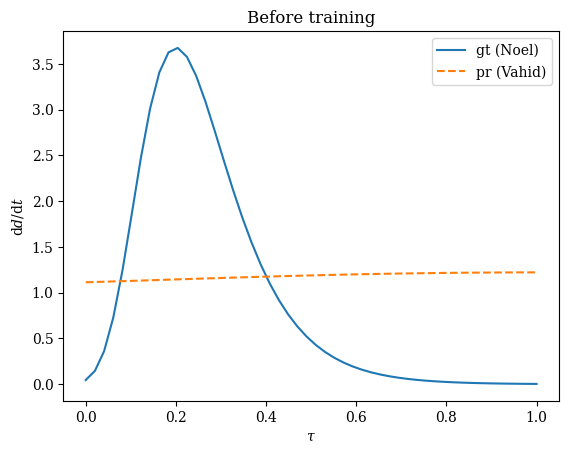

In [261]:
def d_noel(Psi):
    eta = 10.0
    kappa1 = 0.2
    return jnp.exp(-jnp.exp(eta*(kappa1-Psi)))
@jit
def ddot_noel(params, tau, taudot):
    ddot = grad(d_noel)(tau)*taudot
    return ddot
ddot_noel_vmap = vmap(ddot_noel, in_axes=(None, 0, 0))


params = init_params_damage_simple(key)
params_Psi, params_G = params
ddot_pr = ddot_vahid_vmap(params_G, tau, taudot)
ddot_gt = ddot_noel_vmap(None, tau, taudot)

fig, ax = plt.subplots()
ax.plot(tau, ddot_gt,  '-', label='gt (Noel)')
ax.plot(tau, ddot_pr, '--', label='pr (Vahid)')
ax.set(xlabel='$\\tau$', ylabel='$\mathrm{d}d/\mathrm{d}t$', title='Before training'); 
ax.legend(); 

it 10000, train loss = 6.615096e-04
it 20000, train loss = 9.311878e-05
it 30000, train loss = 5.820621e-05
it 40000, train loss = 4.987519e-05
it 50000, train loss = 4.672660e-05
it 60000, train loss = 4.443177e-05
it 70000, train loss = 4.247399e-05
it 80000, train loss = 4.066347e-05
it 90000, train loss = 3.890812e-05
it 100000, train loss = 3.714018e-05


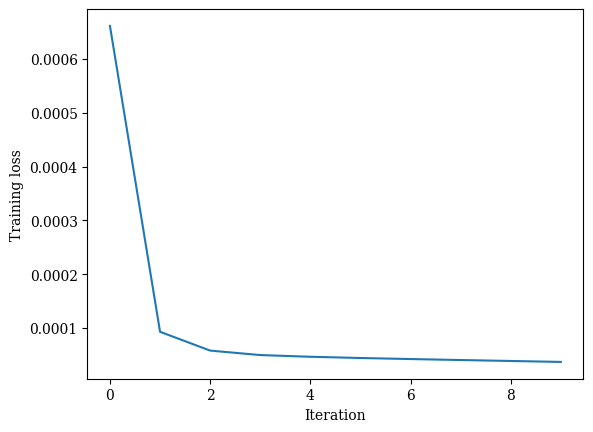

In [278]:
def loss_noel(params):
    tau = np.linspace(0,1)
    taudot = np.ones_like(tau)
    
    ddot_pr = ddot_vahid_vmap(params, tau, taudot)
    ddot_gt = ddot_noel_vmap(None, tau, taudot)
    return jnp.mean((ddot_pr-ddot_gt)**2)

params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
params_Psi, params_G = params
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_G)

# Train
params_G, train_loss, _ = train(loss_noel, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set(xlabel='Iteration', ylabel='Training loss'); 

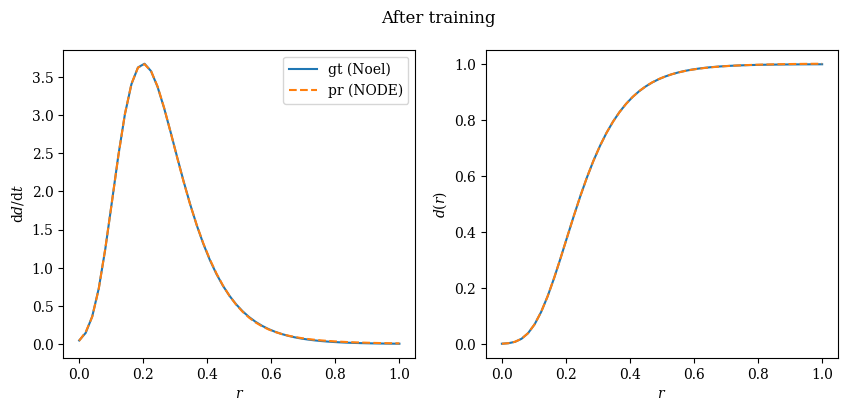

In [279]:
ddot_pr = ddot_vahid_vmap(params_G, tau, taudot)
ddot_gt = ddot_noel_vmap(None, tau, taudot)


fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(tau, ddot_gt,  '-', label='gt (Noel)')
ax[0].plot(tau, ddot_pr, '--', label='pr (NODE)')
ax[0].set(xlabel='$r$', ylabel='$\mathrm{d}d/\mathrm{d}t$'); 
ax[0].legend(); 


d_pr = integrate_damage(params_G, 1.0, ddot_vahid)
d_gt = integrate_damage(params_G, 1.0, ddot_noel)
# d_gt_2 = d_noel(tau)

ax[1].plot(tau, d_gt,  '-', label='gt (Noel)')
ax[1].plot(tau, d_pr, '--', label='pr (NODE)')
ax[1].set(xlabel='$r$', ylabel='$d(r)$')

fig.suptitle('After training'); 
fig.savefig('figs/fig_noel_d_ddot.jpg')

#### Compare stress predictions with this $d(\tau)$

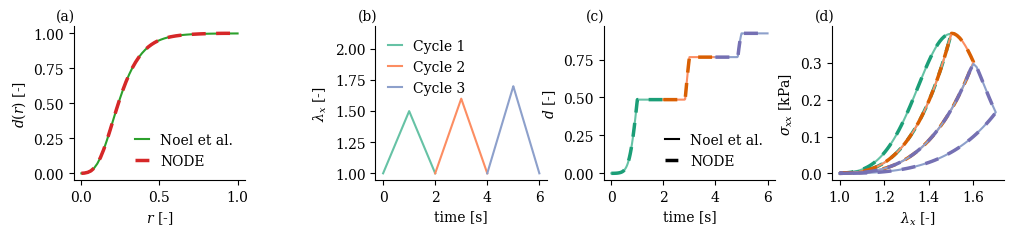

In [290]:
params = [params_Psi, params_G] #append some random params_Psi to the trained params_G, because we need it for stress predictions.
lmbx_max_list = [1.5, 1.6, 1.7]
n_cycles = len(lmbx_max_list)


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig, axes = plot_stress_uniax(lmbx_max_list, ddot_noel, ddot_vahid, params, params, label_gt='Noel et al.', label_pr='NODE'); 

labels='a-bcd'
for label, ax in zip(labels, axes):
    ax.text(-0.1, 1.04, '('+label+')', transform=ax.transAxes)

fig.savefig('figs/fig_noel_d_train.pdf', bbox_inches='tight')

# 2. Ostwald

In [291]:
def d_ostwald(kappa):
    eta_d = 4.0
    kappa_d = 0.0
    return 1.0 - jnp.exp(-eta_d*(kappa-kappa_d))
@jit
def ddot_ostwald(params, tau, taudot):
    ddot = grad(d_ostwald)(tau)*taudot
    return ddot
ddot_ostwald_vmap = vmap(ddot_ostwald, in_axes=(None, 0, 0))

def loss_ostwald(params):
    tau = np.linspace(0,5)
    taudot = np.ones_like(tau)
    
    ddot_pr = ddot_vahid_vmap(params, tau, taudot)
    ddot_gt = ddot_ostwald_vmap(None, tau, taudot)
    return jnp.mean((ddot_pr-ddot_gt)**2)

params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
params_Psi, params_G = params
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_G)

# Train
params_G, train_loss, _ = train(loss_ostwald, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)

it 10000, train loss = 1.286592e-03
it 20000, train loss = 8.518980e-04
it 30000, train loss = 7.805979e-04
it 40000, train loss = 7.466058e-04
it 50000, train loss = 7.236665e-04
it 60000, train loss = 7.066144e-04
it 70000, train loss = 6.956717e-04
it 80000, train loss = 6.877317e-04
it 90000, train loss = 6.816722e-04
it 100000, train loss = 6.766480e-04


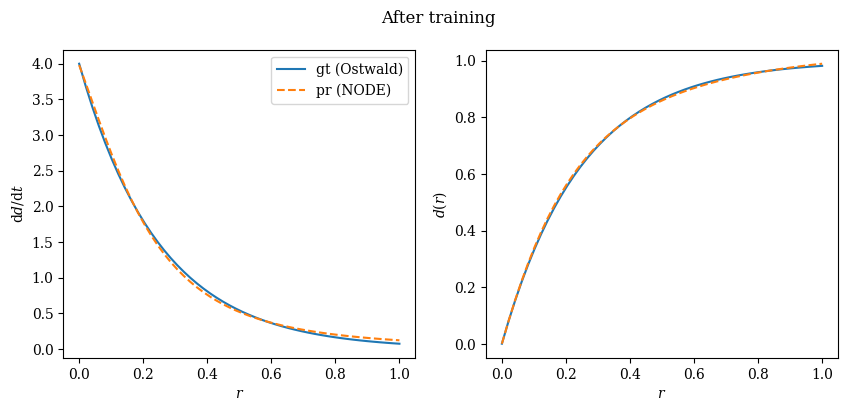

In [292]:
ddot_pr = ddot_vahid_vmap(params_G, tau, taudot)
ddot_gt = ddot_ostwald_vmap(None, tau, taudot)


fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(tau, ddot_gt,  '-', label='gt (Ostwald)')
ax[0].plot(tau, ddot_pr, '--', label='pr (NODE)')
ax[0].set(xlabel='$r$', ylabel='$\mathrm{d}d/\mathrm{d}t$'); 
ax[0].legend(); 


d_pr = integrate_damage(params_G, 1.0, ddot_vahid)
d_gt = integrate_damage(params_G, 1.0, ddot_ostwald)
# d_gt_2 = d_noel(tau)

ax[1].plot(tau, d_gt,  '-', label='gt (Ostwald)')
ax[1].plot(tau, d_pr, '--', label='pr (NODE)')
ax[1].set(xlabel='$r$', ylabel='$d(r)$')

fig.suptitle('After training'); 
fig.savefig('figs/fig_ostwald_d_ddot.jpg')

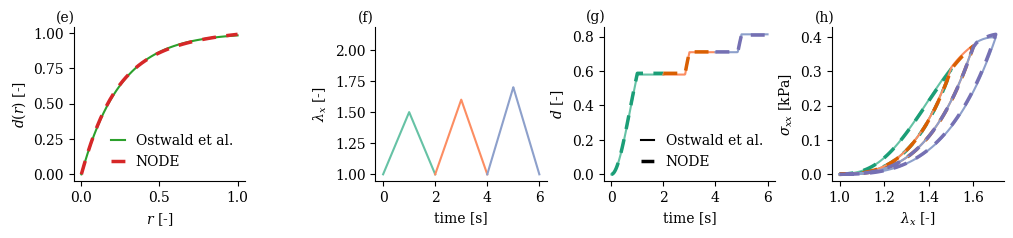

In [293]:
params = [params_Psi, params_G] #append some random params_Psi to the trained params_G, because we need it for stress predictions.
lmbx_max_list = [1.5, 1.6, 1.7]


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig, axes = plot_stress_uniax(lmbx_max_list, ddot_ostwald, ddot_vahid, params, params, label_gt='Ostwald et al.', label_pr='NODE', cycle_legend=False); 

labels='e-fgh'
for label, ax in zip(labels, axes):
    ax.text(-0.1, 1.04, '('+label+')', transform=ax.transAxes)

fig.savefig('figs/fig_ostwald_d_train.pdf', bbox_inches='tight')

# 2. Li

In [294]:
def d_li(tau):
    d_inf = 1.0
    beta = -0.5
    return d_inf*(1.0 - jnp.exp(tau/beta))
@jit
def ddot_li(params, tau, taudot):
    ddot = grad(d_li)(tau)*taudot
    return ddot
ddot_li_vmap = vmap(ddot_li, in_axes=(None, 0, 0))

def loss_li(params):
    tau = np.linspace(0,5)
    taudot = np.ones_like(tau)
    
    ddot_pr = ddot_vahid_vmap(params, tau, taudot)
    ddot_gt = ddot_li_vmap(None, tau, taudot)
    return jnp.mean((ddot_pr-ddot_gt)**2)

params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
params_Psi, params_G = params
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_G)

# Train
params_G, train_loss, _ = train(loss_li, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)

it 10000, train loss = 4.961348e-05
it 20000, train loss = 1.786410e-06
it 30000, train loss = 1.573598e-06
it 40000, train loss = 1.358290e-06
it 50000, train loss = 1.187677e-06
it 60000, train loss = 1.063508e-06
it 70000, train loss = 9.800412e-07
it 80000, train loss = 9.169156e-07
it 90000, train loss = 8.619535e-07
it 100000, train loss = 8.145265e-07


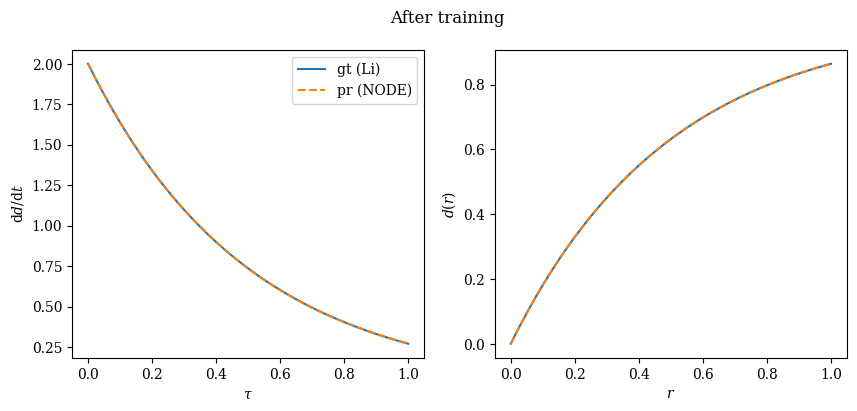

In [295]:
tau = np.linspace(0,1)
ddot_pr = ddot_vahid_vmap(params_G, tau, taudot)
ddot_gt = ddot_li_vmap(None, tau, taudot)


fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(tau, ddot_gt,  '-', label='gt (Li)')
ax[0].plot(tau, ddot_pr, '--', label='pr (NODE)')
ax[0].set(xlabel='$\\tau$', ylabel='$\mathrm{d}d/\mathrm{d}t$'); 
ax[0].legend(); 


d_pr = integrate_damage(params_G, 1.0, ddot_vahid)
d_gt = integrate_damage(params_G, 1.0, ddot_li)
# d_gt_2 = d_noel(tau)

ax[1].plot(tau, d_gt,  '-', label='gt (Li)')
ax[1].plot(tau, d_pr, '--', label='pr (NODE)')
ax[1].set(xlabel='$r$', ylabel='$d(r)$')

fig.suptitle('After training'); 
fig.savefig('figs/fig_li_d_ddot.jpg')

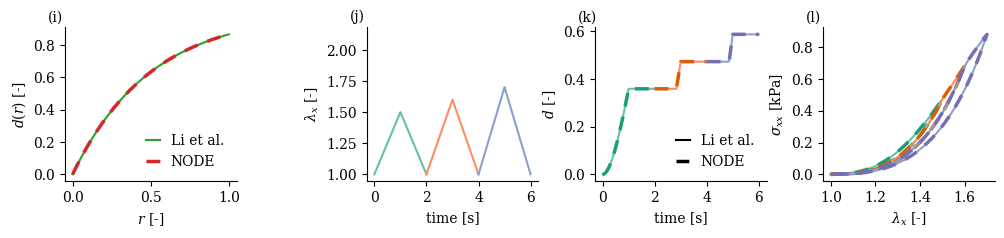

In [296]:
params = [params_Psi, params_G] #append some random params_Psi to the trained params_G, because we need it for stress predictions.
lmbx_max_list = [1.5, 1.6, 1.7]
n_cycles = len(lmbx_max_list)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig, axes = plot_stress_uniax(lmbx_max_list, ddot_li, ddot_vahid, params, params, label_gt='Li et al.', label_pr='NODE', cycle_legend=False); 

labels='i-jkl'
for label, ax in zip(labels, axes):
    ax.text(-0.1, 1.04, '('+label+')', transform=ax.transAxes)

fig.savefig('figs/fig_li_d_train.pdf', bbox_inches='tight')

# Train with stress-strain data

## Noel

In [297]:
lmbx_max_list = [1.5, ]
def loss_stress(params, ddot_gt):
    t, lmbx, d_pr = repeat_uniax(params, lmbx_max_list, ddot_vahid)
    t, lmbx, d_gt = repeat_uniax(params, lmbx_max_list, ddot_gt)
    
    sgmx_gt = []
    sgmx_pr = []
    for i in range(len(lmbx_max_list)):
        lmbx_i = lmbx[i]
        lmby_i = 1.0/jnp.sqrt(lmbx_i)
        di_gt = d_gt[i]
        di_pr = d_pr[i]
        sgmx_gt.append(eval_Cauchy_vmap(lmbx_i, lmby_i, di_gt, params)[:,0,0])
        sgmx_pr.append(eval_Cauchy_vmap(lmbx_i, lmby_i, di_pr, params)[:,0,0])

    sgmx_gt = jnp.array(sgmx_gt).flatten()
    sgmx_pr = jnp.array(sgmx_pr).flatten()
    return jnp.mean((sgmx_gt - sgmx_pr)**2)

### Train with 1 cycle only

it 10000, train loss = 1.481362e-05
it 20000, train loss = 1.167036e-05
it 30000, train loss = 1.130107e-05
it 40000, train loss = 1.121044e-05
it 50000, train loss = 1.117677e-05
it 60000, train loss = 1.116034e-05
it 70000, train loss = 1.115088e-05
it 80000, train loss = 1.114481e-05
it 90000, train loss = 1.114058e-05
it 100000, train loss = 1.113746e-05


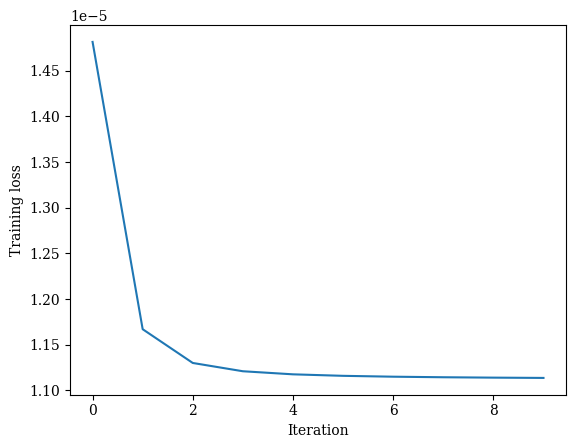

In [159]:
params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
params_Psi, params_G = params
opt_init, opt_update, get_params = optimizers.adam(5.e-5) #Original: 1.e-4
opt_state = opt_init(params_G)
def loss_noel(params_G):
    params = [params_Psi, params_G]
    return loss_stress(params, ddot_noel)

# Train
params_G, train_loss, _ = train(loss_noel, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set(xlabel='Iteration', ylabel='Training loss'); 
params = [params_Psi, params_G]

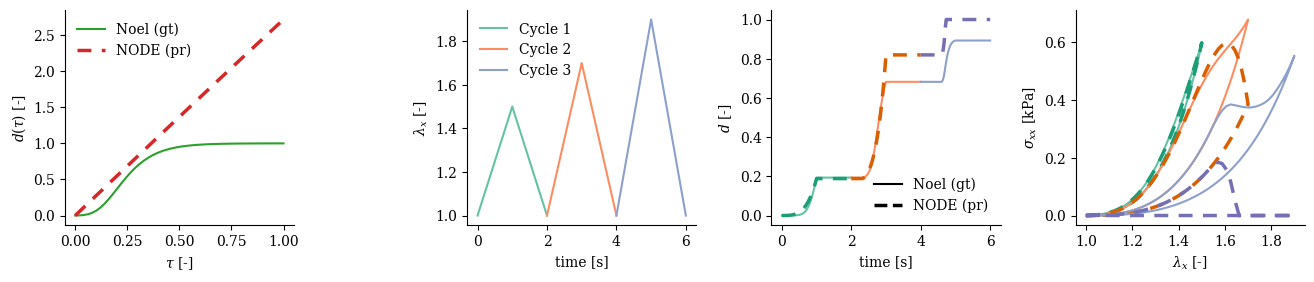

In [160]:
lmbx_max_list = [1.5, 1.7, 1.9]
n_cycles = len(lmbx_max_list)

fig, ax = plot_stress_uniax(lmbx_max_list, ddot_noel, ddot_vahid, params, params, label_gt='Noel (gt)'); 
fig.savefig('figs/fig_noel_stress_train_1cycle.jpg')

### Train with 3 cycles

it 10000, train loss = 4.974718e-04
it 20000, train loss = 4.865790e-04
it 30000, train loss = 3.860926e-06
it 40000, train loss = 1.403779e-06
it 50000, train loss = 2.459636e-07


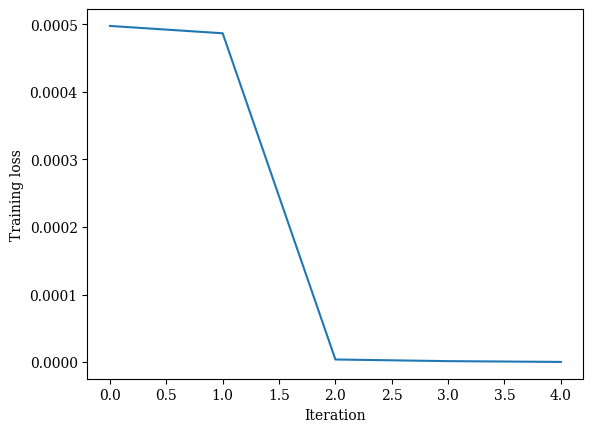

In [300]:
key = random.PRNGKey(2022)
params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
params_Psi, params_G = params
lmbx_max_list = [1.5, 1.6, 1.7]
opt_init, opt_update, get_params = optimizers.adam(5.e-5) #Original: 1.e-4
opt_state = opt_init(params_G)
def loss_noel(params_G):
    params = [params_Psi, params_G]
    return loss_stress(params, ddot_noel)

# Train
params_G, train_loss, _ = train(loss_noel, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=10000)
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set(xlabel='Iteration', ylabel='Training loss'); 
params = [params_Psi, params_G]

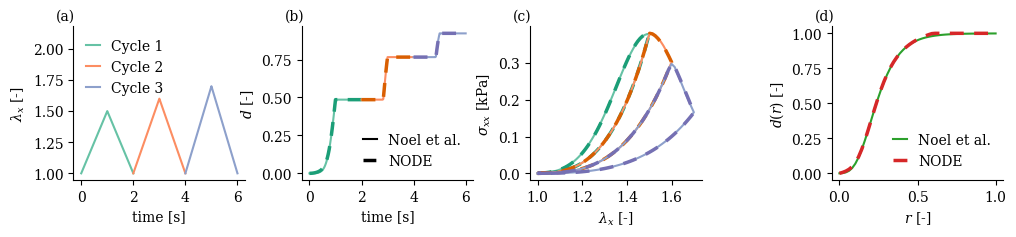

In [301]:
lmbx_max_list = [1.5, 1.6, 1.7]
n_cycles = len(lmbx_max_list)

fig, axes = plot_stress_uniax(lmbx_max_list, ddot_noel, ddot_vahid, params, params, label_pr = 'NODE', label_gt='Noel et al.', d_first=False); 

labels='abc-d'
for label, ax in zip(labels, axes):
    ax.text(-0.1, 1.04, '('+label+')', transform=ax.transAxes)

fig.savefig('figs/fig_noel_stress_train.pdf', bbox_inches='tight')

## Ostwald

it 10000, train loss = 1.784194e-07
it 20000, train loss = 4.265887e-08
it 30000, train loss = 1.269313e-08
it 40000, train loss = 6.029387e-09
it 50000, train loss = 4.279459e-09


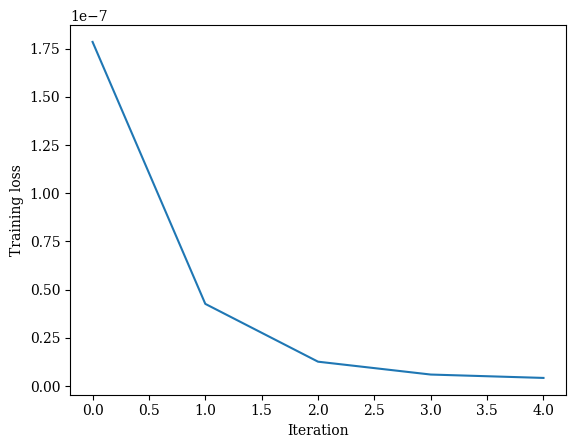

In [303]:
key = random.PRNGKey(2022)
params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
opt_init, opt_update, get_params = optimizers.adam(5.e-5) #Original: 1.e-4
opt_state = opt_init(params_G)
def loss_ostwald(params_G):
    params = [params_Psi, params_G]
    return loss_stress(params, ddot_ostwald)

# Train
params_G, train_loss, _ = train(loss_ostwald, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=10000)
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set(xlabel='Iteration', ylabel='Training loss'); 
params = [params_Psi, params_G]

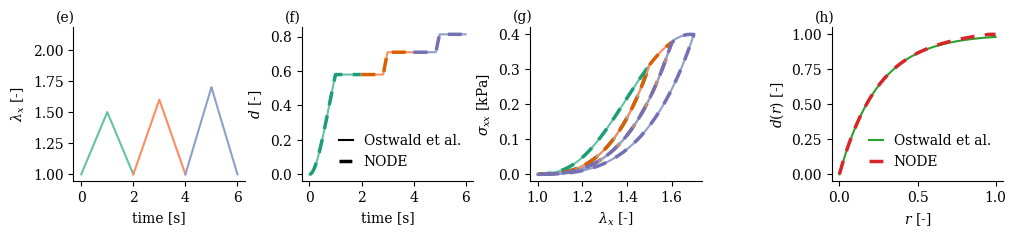

In [304]:
lmbx_max_list = [1.5, 1.6, 1.7]
n_cycles = len(lmbx_max_list)

fig, axes = plot_stress_uniax(lmbx_max_list, ddot_ostwald, ddot_vahid, params, params, label_pr = 'NODE', label_gt='Ostwald et al.', d_first=False, cycle_legend=False); 
labels='efg-h'
for label, ax in zip(labels, axes):
    ax.text(-0.1, 1.04, '('+label+')', transform=ax.transAxes)

fig.savefig('figs/fig_ostwald_stress_train.pdf', bbox_inches='tight')

## Li

it 10000, train loss = 1.427500e-06
it 20000, train loss = 3.451044e-09
it 30000, train loss = 1.187674e-09
it 40000, train loss = 7.067542e-10
it 50000, train loss = 3.766197e-10


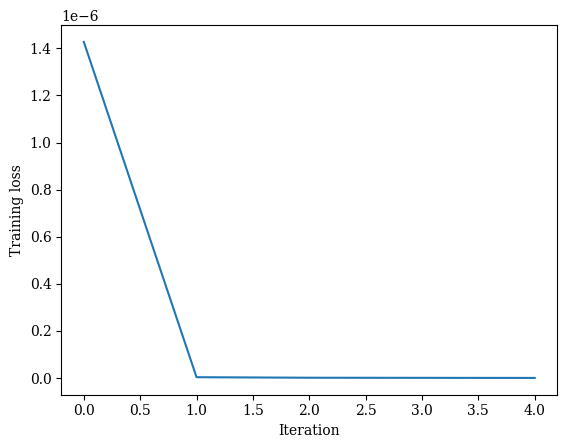

In [305]:
key = random.PRNGKey(2022)
params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
opt_init, opt_update, get_params = optimizers.adam(5.e-5) #Original: 1.e-4
opt_state = opt_init(params_G)
def loss_li(params_G):
    params = [params_Psi, params_G]
    return loss_stress(params, ddot_li)

# Train
params_G, train_loss, _ = train(loss_li, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=10000)
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set(xlabel='Iteration', ylabel='Training loss'); 
params = [params_Psi, params_G]

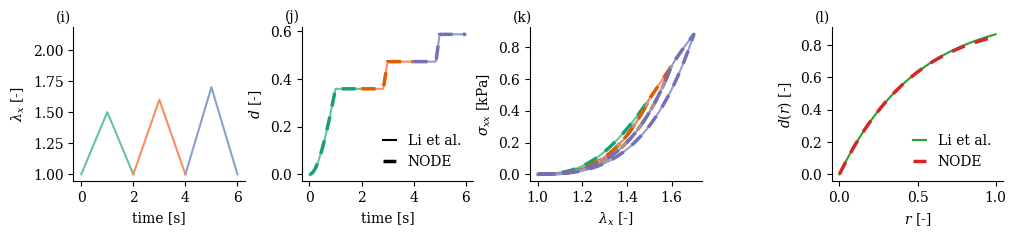

In [306]:
lmbx_max_list = [1.5, 1.6, 1.7]
n_cycles = len(lmbx_max_list)

fig, axes = plot_stress_uniax(lmbx_max_list, ddot_li, ddot_vahid, params, params, label_pr='NODE', label_gt='Li et al.', d_first=False, cycle_legend=False); 

labels='ijk-l'
for label, ax in zip(labels, axes):
    ax.text(-0.1, 1.04, '('+label+')', transform=ax.transAxes)

fig.savefig('figs/fig_li_stress_train.pdf', bbox_inches='tight')